In [49]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os 

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
DIRECTORY = r"C:\Users\vasu2\Desktop\Mask Detection Test\maskdata\maskdata\train"
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []

In [15]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [16]:
def show(index):
    plt.imshow(data[index])
    plt.xlabel(labels[index])

In [17]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [18]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [19]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [20]:
trainX[0]

array([[[-0.2235294 , -0.49019605, -0.8509804 ],
        [-0.2235294 , -0.49019605, -0.8509804 ],
        [-0.21568626, -0.4823529 , -0.84313726],
        ...,
        [ 0.3803922 ,  0.6627451 ,  0.8666667 ],
        [ 0.78039217,  0.9372549 ,  1.        ],
        [ 0.8901961 ,  1.        ,  1.        ]],

       [[-0.2235294 , -0.49019605, -0.8509804 ],
        [-0.2235294 , -0.49019605, -0.8509804 ],
        [-0.21568626, -0.4823529 , -0.84313726],
        ...,
        [ 0.3803922 ,  0.6627451 ,  0.8666667 ],
        [ 0.78039217,  0.9372549 ,  1.        ],
        [ 0.8901961 ,  1.        ,  1.        ]],

       [[-0.23137254, -0.4980392 , -0.85882354],
        [-0.23137254, -0.4980392 , -0.85882354],
        [-0.2235294 , -0.49019605, -0.8509804 ],
        ...,
        [ 0.3803922 ,  0.6627451 ,  0.8666667 ],
        [ 0.7882353 ,  0.94509804,  1.        ],
        [ 0.8980392 ,  1.        ,  1.        ]],

       ...,

       [[-0.67058825, -0.7254902 , -0.8039216 ],
        [-0

In [25]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3))

9412608/9406464 [==============================] - 1s 0us/step


In [35]:
cnn = baseModel.output
cnn = MaxPooling2D(pool_size=(7, 7))(cnn)
cnn = Flatten(name="flatten")(cnn)
cnn = Dense(128, activation="relu")(cnn)
cnn = Dropout(0.5)(cnn)
cnn = Dense(2, activation="softmax")(cnn)

In [38]:
model = Model(inputs=baseModel.input, outputs=cnn)

In [42]:
for layer in baseModel.layers:
    layer.trainable = False

In [50]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [52]:
LR = 1e-4
E = 35
BS = 32

In [53]:
opt = Adam(lr=LR, decay=LR / E) 
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [54]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=E)

Epoch 1/35
15/15 [==============================] - 14s 775ms/step - loss: 0.1211 - accuracy: 0.9735 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 2/35
15/15 [==============================] - 11s 748ms/step - loss: 0.0635 - accuracy: 0.9848 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 3/35
15/15 [==============================] - 11s 747ms/step - loss: 0.0817 - accuracy: 0.9706 - val_loss: 0.0114 - val_accuracy: 1.0000
Epoch 4/35
15/15 [==============================] - 11s 753ms/step - loss: 0.0609 - accuracy: 0.9812 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 5/35
15/15 [==============================] - 12s 797ms/step - loss: 0.0515 - accuracy: 0.9885 - val_loss: 0.0131 - val_accuracy: 0.9919
Epoch 6/35
15/15 [==============================] - 12s 783ms/step - loss: 0.0424 - accuracy: 0.9876 - val_loss: 0.0109 - val_accuracy: 1.0000
Epoch 7/35
15/15 [==============================] - 12s 815ms/step - loss: 0.0189 - accuracy: 0.9974 - val_loss: 0.0109 - val_accuracy: 1.0000

In [55]:
predIdxs = model.predict(testX, batch_size=BS)

In [56]:
predIdxs = np.argmax(predIdxs, axis=1)

In [57]:
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00        69
without_mask       1.00      1.00      1.00        55

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124



Text(0.5, 0, 'Epoch ----->')

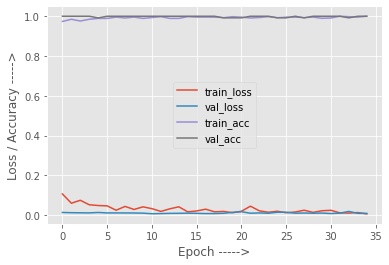

In [68]:
N = E
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.legend(loc="center")
plt.ylabel("Loss / Accuracy ----->")
plt.xlabel("Epoch ----->")

In [69]:
model.save("MaskDetectionModel", save_format="h5")